In [1]:
import numpy as np 
import pandas as pd

## 1. Importando os dados e criando os arrays "images" e "labels"

In [2]:
from PIL import Image
from os import listdir
from os.path import isdir

In [3]:
def create_dataset(diretorio): 

    images = list() 
    labels = list()  

    for subdir in listdir(diretorio): 

        path_1 = diretorio + "/" + subdir + "/"

        for filename in listdir(path_1):

            path_2 = path_1 + filename
            image = Image.open(path_2)
            image = image.convert("RGB")
            image = image.resize((150, 150))
            image_array = np.asarray(image)

            images.append(image_array)
            labels.append(subdir)

    return images, labels

In [4]:
name_dir = "/home/isabella/Documents/projects/grapevine_disesase/dataset"

images, labels = create_dataset(name_dir)

In [5]:
# Transformando images e labels em arrays do numpy

images = np.asarray(images)
labels = np.asarray(labels)

# Os valores dos pixels variam de 0-255
# É necessário padronizá-los no range 0-1

images = images / 255.0

In [6]:
# Transformando o label em classes 0 (healthy) e 1 (disease)

classes = {"grape_healthy": 0, "grape_black_rot": 1}
labels = np.vectorize(classes.get)(labels)

0


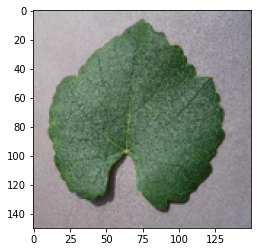

In [7]:
import matplotlib.pyplot as plt
print(labels[100])
plt.imshow(images[100])
plt.show()

## 3. Cross-validação

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [9]:
skf = StratifiedKFold(n_splits=5)

In [10]:
scores = {"auc": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "confusion_matrix": []}

for train_index, test_index in skf.split(images, labels):
    print("quantidade de exemplos em cada classe no treino - {} | teste - {}".format(np.bincount(labels[train_index]), np.bincount(labels[test_index])))

    #### MODELO ####
    model = models.Sequential()
    # Primeira camada convolucional
    model.add(layers.Conv2D(filters = 50, kernel_size = (5, 5), input_shape = (150, 150, 3), activation = "relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size = (2, 2)))
    # Segunda camada convolucional
    model.add(layers.Conv2D(filters = 32, kernel_size = (5, 5), activation = "relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size = (2, 2)))
    # Camada de flatten
    model.add(layers.Flatten())
    # Primeira camada oculta da rede neural
    model.add(layers.Dense(units = 128, activation = "relu"))
    model.add(layers.Dropout(rate = 0.2))
    # Segunda camada oculta da rede neural
    model.add(layers.Dense(units = 128, activation = "relu"))
    model.add(layers.Dropout(rate = 0.2))
    # Camada de saída da rede neural
    model.add(layers.Dense(units = 1, activation = "sigmoid"))


    model.compile(loss="binary_crossentropy", 
                  optimizer="adam",
                  metrics=[AUC()])
    
    model.fit(images[train_index],
              labels[train_index],
              batch_size=50,
              epochs=25,
              class_weight={0:1.89479, 1:0.67923},
              validation_data=(images[test_index],labels[test_index]))
    
    #### PREVISÕES ####
    p = model.predict(images[test_index])
    pclass = (p > 0.5).astype("int32")
    
    #### MÉTRICAS ####
    scores["auc"].append(roc_auc_score(labels[test_index], pclass))
    scores["accuracy"].append(accuracy_score(labels[test_index], pclass))
    scores["precision"].append(precision_score(labels[test_index], pclass))
    scores["recall"].append(recall_score(labels[test_index], pclass))
    scores["f1"].append(f1_score(labels[test_index], pclass))
    scores["confusion_matrix"].append(confusion_matrix(labels[test_index], pclass))

    print(confusion_matrix(labels[test_index], pclass))
    print("\n")

quantidade de exemplos em cada classe no treino - [338 944] | teste - [ 85 236]
Epoch 1/25
26/26 [==============================] - 66s 3s/step - loss: 0.6835 - auc: 0.9522 - val_loss: 2.5740 - val_auc: 0.6393
Epoch 2/25
26/26 [==============================] - 66s 3s/step - loss: 0.2459 - auc: 0.9870 - val_loss: 22.5825 - val_auc: 0.5000
Epoch 3/25
26/26 [==============================] - 74s 3s/step - loss: 0.2221 - auc: 0.9857 - val_loss: 29.4224 - val_auc: 0.5000
Epoch 4/25
26/26 [==============================] - 67s 3s/step - loss: 0.3203 - auc: 0.9819 - val_loss: 48.2503 - val_auc: 0.5000
Epoch 5/25
26/26 [==============================] - 68s 3s/step - loss: 0.4229 - auc: 0.9784 - val_loss: 49.1271 - val_auc: 0.5000
Epoch 6/25
26/26 [==============================] - 68s 3s/step - loss: 0.2528 - auc: 0.9872 - val_loss: 70.0397 - val_auc: 0.5000
Epoch 7/25
26/26 [==============================] - 68s 3s/step - loss: 0.2565 - auc: 0.9858 - val_loss: 80.8789 - val_auc: 0.5000
Epoc

## 4. Visualizando os resultados

In [44]:
cv_results = pd.DataFrame.from_dict(data=scores, orient="index", columns=["fold_1", "fold_2", "fold_3", "fold_4", "fold_5"])
cv_results["mean"] = cv_results.iloc[0:5,:].mean(axis=1)
cv_results["std"] = cv_results.iloc[0:5,:].std(axis=1)
cv_results.T

,auc,accuracy,precision,recall,f1,confusion_matrix
fold_1,0.983524,0.981308,0.99569,0.978814,0.987179,"[[84, 1], [5, 231]]"
fold_2,0.983998,0.987539,0.991525,0.991525,0.991525,"[[83, 2], [2, 234]]"
fold_3,0.917647,0.956386,0.944,1,0.971193,"[[71, 14], [0, 236]]"
fold_4,0.989407,0.984375,1,0.978814,0.989293,"[[84, 0], [5, 231]]"
fold_5,0.955508,0.934375,1,0.911017,0.953437,"[[84, 0], [21, 215]]"
mean,0.966017,0.968797,0.986243,0.972034,0.978526,NaN
std,0.0269332,0.020442,0.0213547,0.03155,0.0144433,NaN
